##### データセットの場所やバッチサイズなどの定数値の設定

In [34]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'


# 前回の試行の続きを行いたい場合は True にする -> 再開モードになる．
# なお，Colab環境で再開モードを利用する場合は，前回終了時に temp ディレクトリの中身を自分の Google Drive に退避しておき，
# それを改めて /content/AI_advanced/temp 以下にあらかじめ移しておく必要がある．
RESTART_MODE = False

DEVICE = 'cuda:0'

N_EPOCHS = 1

# 学習時のバッチサイズ
BATCH_SIZE = 100

# データセットの存在するフォルダ・ファイル名
DATA_DIR = './data/MNIST'
TRAIN_IMAGES_FILE = 'MNIST_train_images.pt'
VALID_IMAGES_FILE = 'MNIST_valid_images.pt'

# 特徴ベクトルの次元数
N = 32

# バッチ正規化を使用するか否か
USE_BATCH_NORM = False

# 学習結果の保存先フォルダ 変更すること
MODEL_DIR = './models/MNIST/AE/'

# 学習結果のニューラルネットワークの保存先
MODEL_FILE_ENC = os.path.join(MODEL_DIR, f'{N}_encoder.pth') # エンコーダ
MODEL_FILE_DEC = os.path.join(MODEL_DIR, f'{N}_decoder.pth') # デコーダ

# 中断／再開の際に用いる一時ファイルの保存先
#####       一旦置いとく・・・・        #####
CHECKPOINT_EPOCH = os.path.join('./temp/', 'checkpoint_epoch.pkl')
CHECKPOINT_ENC_MODEL = os.path.join('./temp/', 'checkpoint_enc_model.pth')
CHECKPOINT_DEC_MODEL = os.path.join('./temp/', 'checkpoint_dec_model.pth')
CHECKPOINT_ENC_OPT = os.path.join('./temp/', 'checkpoint_enc_opt.pth')
CHECKPOINT_DEC_OPT = os.path.join('./temp/', 'checkpoint_dec_opt.pth')

##### ニューラルネットワークモデルの定義

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# MNIST画像を N 次元の特徴ベクトルへと圧縮するニューラルネットワーク
# AutoEncoder のエンコーダ部分のサンプル
class MNISTEncoder(nn.Module):

    # N: 出力の特徴ベクトルの次元数
    def __init__(self, N, use_BatchNorm=False):
        super(MNISTEncoder, self).__init__()

        # 畳込み層1,2
        # カーネルサイズ4，ストライド幅2，パディング1の設定なので，これらを通すことにより特徴マップの縦幅・横幅がそれぞれ 1/2 になる
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=1)

        # 畳込み層3
        # カーネルサイズ3，ストライド幅1，パディング1の設定なので，これを通しても特徴マップの縦幅・横幅は変化しない
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)

        # バッチ正規化層
        self.use_BatchNorm = use_BatchNorm
        if use_BatchNorm:
            self.bn1 = nn.BatchNorm2d(num_features=4) # num_features は conv1 の out_channels と同じ値に
            self.bn2 = nn.BatchNorm2d(num_features=8) # num_features は conv2 の out_channels と同じ値に
            self.bn3 = nn.BatchNorm2d(num_features=8) # num_features は conv3 の out_channels と同じ値に

        # 平坦化
        self.flat = nn.Flatten()

        ## Live Share!!!!!!!!!!!!!!!!!!
        # 全結合層
        # 畳込み層1, 2を通すことにより特徴マップの縦幅・横幅は 28/4 = 7 になっている．
        # その後，さらに self.conv3 を通してから全結合層を適用する予定なので，入力側のパーセプトロン数は 8*7*7
        self.fc = nn.Linear(in_features=8*7*7, out_features=N)

    def forward(self, x):
        if self.use_BatchNorm:
            h = F.leaky_relu(self.bn1(self.conv1(x)))
            h = F.leaky_relu(self.bn2(self.conv2(h)))
            h = F.leaky_relu(self.bn3(self.conv3(h)))
        else:
            h = F.leaky_relu(self.conv1(x))
            h = F.leaky_relu(self.conv2(h))
            h = F.leaky_relu(self.conv3(h))
        h = self.flat(h)
        z = self.fc(h)
        return z


# MNIST画像を N 次元の特徴ベクトルへと圧縮するニューラルネットワーク（VAE版）
# Variational AutoEncoder のエンコーダ部分のサンプル
class MNISTEncoderV(nn.Module):

    # N: 出力の特徴ベクトルの次元数
    def __init__(self, N, use_BatchNorm=False):
        super(MNISTEncoderV, self).__init__()

        # 畳込み層1,2
        # カーネルサイズ4，ストライド幅2，パディング1の設定なので，これらを通すことにより特徴マップの縦幅・横幅がそれぞれ 1/2 になる
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2, padding=1)

        # 畳込み層3
        # カーネルサイズ3，ストライド幅1，パディング1の設定なので，これを通しても特徴マップの縦幅・横幅は変化しない
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)

        # バッチ正規化層
        self.use_BatchNorm = use_BatchNorm
        if use_BatchNorm:
            self.bn1 = nn.BatchNorm2d(num_features=4) # num_features は conv1 の out_channels と同じ値に
            self.bn2 = nn.BatchNorm2d(num_features=8) # num_features は conv2 の out_channels と同じ値に
            self.bn3 = nn.BatchNorm2d(num_features=8) # num_features は conv3 の out_channels と同じ値に

        # 平坦化
        self.flat = nn.Flatten()

        # 全結合層
        # 畳込み層1, 2を通すことにより特徴マップの縦幅・横幅は 28/4 = 7 になっている．
        # その後，さらに self.conv3 を通してから全結合層を適用する予定なので，入力側のパーセプトロン数は 8*7*7
        self.fc_mu = nn.Linear(in_features=8*7*7, out_features=N)
        self.fc_lnvar = nn.Linear(in_features=8*7*7, out_features=N)

    def forward(self, x):
        if self.use_BatchNorm:
            h = F.leaky_relu(self.bn1(self.conv1(x)))
            h = F.leaky_relu(self.bn2(self.conv2(h)))
            h = F.leaky_relu(self.bn3(self.conv3(h)))
        else:
            h = F.leaky_relu(self.conv1(x))
            h = F.leaky_relu(self.conv2(h))
            h = F.leaky_relu(self.conv3(h))
        h = self.flat(h)
        mu = self.fc_mu(h)
        lnvar = self.fc_lnvar(h)
        eps = torch.randn_like(mu) # mu と同じサイズの標準正規乱数を生成
        z = mu + eps * torch.exp(0.5 * lnvar)
        return z, mu, lnvar


# N 次元の特徴ベクトルからMNIST風画像を生成するニューラルネットワーク
# AutoEncoder および Variational AutoEncoder のデコーダ部分のサンプル（デコーダ部分は通常の AE と VAE で全く同じ）
class MNISTDecoder(nn.Module):

    # N: 入力の特徴ベクトルの次元数
    def __init__(self, N, use_BatchNorm=False):
        super(MNISTDecoder, self).__init__()

        # 全結合層
        # パーセプトロン数は MNISTEncoder の全結合層と真逆に設定
        self.fc = nn.Linear(in_features=N, out_features=8*7*7)

        # 転置畳込み層1～3
        # カーネルサイズ，ストライド幅，パディングは MNISTEncoder の畳込み層1～3と真逆に設定
        self.deconv3 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=4, stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(in_channels=4, out_channels=4, kernel_size=4, stride=2, padding=1)

        # 畳込み層
        # 転置畳込み層の出力には checker board artifact というノイズが乗りやすいので，最後に畳込み層を通しておく
        self.conv = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, stride=1, padding=1)

        # バッチ正規化層
        self.use_BatchNorm = use_BatchNorm
        if use_BatchNorm:
            self.bn3 = nn.BatchNorm2d(num_features=8)
            self.bn2 = nn.BatchNorm2d(num_features=4)
            self.bn1 = nn.BatchNorm2d(num_features=4)

    def forward(self, z):
        h = F.leaky_relu(self.fc(z))
        h = torch.reshape(h, (len(h), 8, 7, 7)) # 一列に並んだユニットを 8*7*7 の特徴マップに並べ直す
        if self.use_BatchNorm:
            h = F.leaky_relu(self.bn3(self.deconv3(h)))
            h = F.leaky_relu(self.bn2(self.deconv2(h)))
            h = F.leaky_relu(self.bn1(self.deconv1(h)))
        else:
            h = F.leaky_relu(self.deconv3(h))
            h = F.leaky_relu(self.deconv2(h))
            h = F.leaky_relu(self.deconv1(h))
        y = torch.sigmoid(self.conv(h))
        return y

##### 訓練データセットの読み込み

In [32]:
import torch
from torch.utils.data import DataLoader, random_split
from src.utils.data_io import TensorDataset


# 再開モードの場合は，前回使用したデータセットをロードして使用する
if RESTART_MODE:

    # テンソルファイルを読み込み，前回使用したデータセットを用意
    train_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', TRAIN_IMAGES_FILE)
    ])
    valid_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', VALID_IMAGES_FILE)
    ])
    train_size = len(train_dataset)
    valid_size = len(valid_dataset)

# そうでない場合は，新たにデータセットを読み込む
else:

    # テンソルファイルを読み込み, 訓練データセットを用意
    dataset = TensorDataset(filenames=[
        os.path.join(DATA_DIR, TRAIN_IMAGES_FILE)
    ])

    # 訓練データセットを分割し，一方を検証用に回す
    dataset_size = len(dataset)
    valid_size = int(0.01 * dataset_size) # 全体の 1% を検証用に
    train_size = dataset_size - valid_size # 残りの 99% を学習用に
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

    # データセット情報をファイルに保存
    torch.save(torch.cat([torch.unsqueeze(train_dataset[i], dim=0) for i in range(len(train_dataset))], dim=0), os.path.join('./temp/', TRAIN_IMAGES_FILE))
    torch.save(torch.cat([torch.unsqueeze(valid_dataset[i], dim=0) for i in range(len(valid_dataset))], dim=0), os.path.join('./temp/', VALID_IMAGES_FILE))


# 訓練データおよび検証用データをミニバッチに分けて使用するための「データローダ」を用意
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8)

##### 学習処理の実行（通常のAE）

Epoch 1:


100%|██████████| 594/594 [00:05<00:00, 108.24it/s]


train loss = 0.072956


100%|██████████| 6/6 [00:00<00:00, 14.48it/s]


valid loss = 0.035099



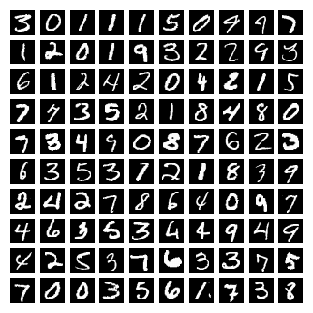

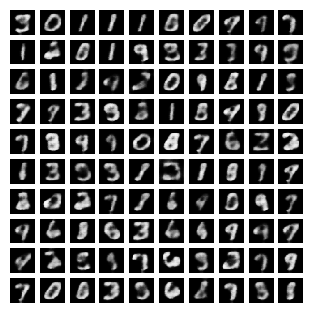

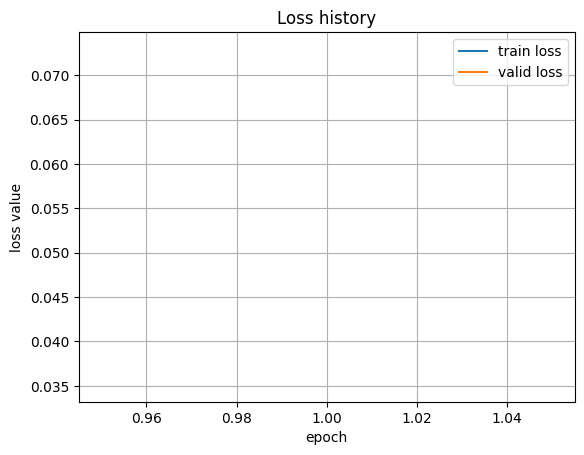

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.utils.visualizers import LossVisualizer
from src.utils.data_io import show_images
from src.utils.utility import save_checkpoint, load_checkpoint
import shutil

# ./temp ディレクトリの中身を全て削除
if os.path.exists('./temp'):
    shutil.rmtree('./temp')
    os.makedirs('./temp')
    
# エポック番号
INIT_EPOCH = 0 # 初期値
LAST_EPOCH = INIT_EPOCH + N_EPOCHS # 最終値

# ニューラルネットワークの作成
enc_model = MNISTEncoder(N=N, use_BatchNorm=USE_BATCH_NORM).to(DEVICE)
dec_model = MNISTDecoder(N=N, use_BatchNorm=USE_BATCH_NORM).to(DEVICE)

# 最適化アルゴリズムの指定（ここでは SGD でなく Adam を使用）
enc_optimizer = optim.Adam(enc_model.parameters())
dec_optimizer = optim.Adam(dec_model.parameters())

# 再開モードの場合は，前回チェックポイントから情報をロードして学習再開
if RESTART_MODE:
    print('Loading checkpoint ...')
    INIT_EPOCH, LAST_EPOCH, enc_model, enc_optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_ENC_MODEL, CHECKPOINT_ENC_OPT, N_EPOCHS, enc_model, enc_optimizer)
    _, _, dec_model, dec_optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_DEC_MODEL, CHECKPOINT_DEC_OPT, N_EPOCHS, dec_model, dec_optimizer)
    print('')

# 損失関数： 平均二乗誤差損失を使用（これが最適とは限らない．平均絶対誤差損失 nn.L1Loss() なども考えられる）
loss_func = nn.MSELoss()

# 損失関数値を記録する準備
loss_viz = LossVisualizer(['train loss', 'valid loss'], init_epoch=INIT_EPOCH)

# 勾配降下法による繰り返し学習
for epoch in range(INIT_EPOCH, LAST_EPOCH):

    print('Epoch {0}:'.format(epoch + 1))

    # 学習
    enc_model.train()
    dec_model.train()
    sum_loss = 0
    for X in tqdm(train_dataloader):
        for param in enc_model.parameters():
            param.grad = None
        for param in dec_model.parameters():
            param.grad = None
        X = X.to(DEVICE)
        Z = enc_model(X) # 入力画像 X を現在のエンコーダに入力し，特徴ベクトル Z を得る
        Y = dec_model(Z) # 特徴ベクトル Z を現在のデコーダに入力し，復元画像 Y を得る
        loss = loss_func(X, Y) # 損失関数の現在値を計算
        loss.backward() # 誤差逆伝播法により，個々のパラメータに関する損失関数の勾配（偏微分）を計算
        enc_optimizer.step() # 勾配に沿ってパラメータの値を更新
        dec_optimizer.step() # 同上
        sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / train_size
    loss_viz.add_value('train loss', avg_loss) # 訓練データに対する損失関数の値を記録
    print('train loss = {0:.6f}'.format(avg_loss))

    # 検証
    enc_model.eval()
    dec_model.eval()
    sum_loss = 0
    with torch.inference_mode():
        for X in tqdm(valid_dataloader):
            X = X.to(DEVICE)
            Z = enc_model(X)
            Y = dec_model(Z)
            loss = loss_func(X, Y)
            sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / valid_size
    loss_viz.add_value('valid loss', avg_loss) # 検証用データに対する損失関数の値を記録
    print('valid loss = {0:.6f}'.format(avg_loss))
    print('')

    # 学習経過の表示
    if epoch == 0:
        show_images(X.to('cpu').detach(), num=BATCH_SIZE, title='original', save_fig=False, save_dir=MODEL_DIR)
    show_images(Y.to('cpu').detach(), num=BATCH_SIZE, title='epoch {0}'.format(epoch + 1), save_fig=False, save_dir=MODEL_DIR)

    # 現在の学習状態を一時ファイル（チェックポイント）に保存
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_ENC_MODEL, CHECKPOINT_ENC_OPT, epoch+1, enc_model, enc_optimizer)
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_DEC_MODEL, CHECKPOINT_DEC_OPT, epoch+1, dec_model, dec_optimizer)

# 学習結果のニューラルネットワークモデルをファイルに保存
enc_model = enc_model.to('cpu')
dec_model = dec_model.to('cpu')
torch.save(enc_model.state_dict(), MODEL_FILE_ENC)
torch.save(dec_model.state_dict(), MODEL_FILE_DEC)

# 損失関数の記録をファイルに保存
loss_viz.save(v_file=os.path.join(MODEL_DIR, f'{N}_loss_graph.png'), h_file=os.path.join(MODEL_DIR, f'{N}_loss_history.csv'))

##### 学習処理の実行（VAE）

Epoch 1:


100%|██████████| 594/594 [00:07<00:00, 82.43it/s]


train loss = 0.328689


100%|██████████| 6/6 [00:00<00:00, 14.13it/s]


valid loss = 0.248361



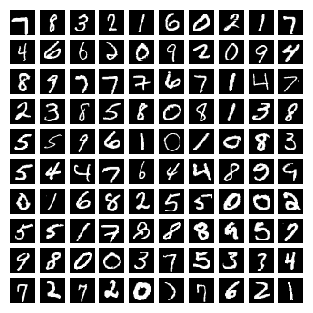

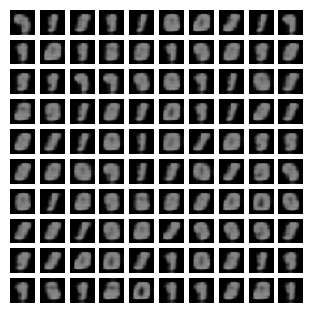

Epoch 2:


100%|██████████| 594/594 [00:06<00:00, 93.67it/s] 


train loss = 0.219227


100%|██████████| 6/6 [00:00<00:00, 14.91it/s]


valid loss = 0.181869



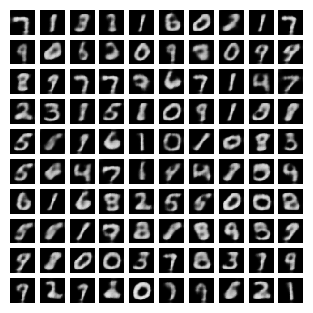

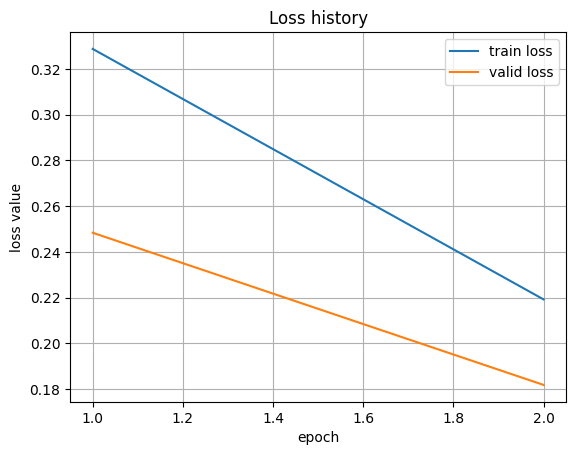

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from src.utils.loss_functions import VAELoss
from src.utils.visualizers import LossVisualizer
from src.utils.data_io import show_images
from src.utils.utility import save_checkpoint, load_checkpoint


# エポック番号
INIT_EPOCH = 0 # 初期値
LAST_EPOCH = INIT_EPOCH + N_EPOCHS # 最終値

# ニューラルネットワークの作成
enc_model = MNISTEncoderV(N=N, use_BatchNorm=USE_BATCH_NORM).to(DEVICE)
dec_model = MNISTDecoder(N=N, use_BatchNorm=USE_BATCH_NORM).to(DEVICE)

# 最適化アルゴリズムの指定（ここでは SGD でなく Adam を使用）
enc_optimizer = optim.Adam(enc_model.parameters())
dec_optimizer = optim.Adam(dec_model.parameters())

# 再開モードの場合は，前回チェックポイントから情報をロードして学習再開
if RESTART_MODE:
    INIT_EPOCH, LAST_EPOCH, enc_model, enc_optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_ENC_MODEL, CHECKPOINT_ENC_OPT, N_EPOCHS, enc_model, enc_optimizer)
    _, _, dec_model, dec_optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_DEC_MODEL, CHECKPOINT_DEC_OPT, N_EPOCHS, dec_model, dec_optimizer)
    print('')

# 損失関数（VAE用の損失関数を使用．具体的な実装は mylib/loss_functions.py を参照）
loss_func = VAELoss(alpha=0.1)

# 損失関数値を記録する準備
loss_viz = LossVisualizer(['train loss', 'valid loss'], init_epoch=INIT_EPOCH)

# 勾配降下法による繰り返し学習
for epoch in range(INIT_EPOCH, LAST_EPOCH):

    print('Epoch {0}:'.format(epoch + 1))

    # 学習
    enc_model.train()
    dec_model.train()
    sum_loss = 0
    for X in tqdm(train_dataloader):
        for param in enc_model.parameters():
            param.grad = None
        for param in dec_model.parameters():
            param.grad = None
        X = X.to(DEVICE)
        Z, mu, lnvar = enc_model(X) # 入力画像 X を現在のエンコーダに入力し，特徴ベクトル Z を得る
        Y = dec_model(Z) # 特徴ベクトル Z を現在のデコーダに入力し，復元画像 Y を得る
        loss = loss_func(Y, X, mu, lnvar) # 損失関数の現在値を計算
        loss.backward() # 誤差逆伝播法により，個々のパラメータに関する損失関数の勾配（偏微分）を計算
        enc_optimizer.step() # 勾配に沿ってパラメータの値を更新
        dec_optimizer.step() # 同上
        sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / train_size
    loss_viz.add_value('train loss', avg_loss) # 訓練データに対する損失関数の値を記録
    print('train loss = {0:.6f}'.format(avg_loss))

    # 検証
    enc_model.eval()
    dec_model.eval()
    sum_loss = 0
    with torch.inference_mode():
        for X in tqdm(valid_dataloader):
            X = X.to(DEVICE)
            Z, mu, lnvar = enc_model(X)
            Y = dec_model(mu) # 生成時は分布の平均 mu をそのままデコーダに入れる
            loss = loss_func(Y, X, mu, lnvar)
            sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / valid_size
    loss_viz.add_value('valid loss', avg_loss) # 検証用データに対する損失関数の値を記録
    print('valid loss = {0:.6f}'.format(avg_loss))
    print('')

    # 学習経過の表示
    if epoch == 0:
        show_images(X.to('cpu').detach(), num=BATCH_SIZE, title='original', save_fig=False, save_dir=MODEL_DIR)
    show_images(Y.to('cpu').detach(), num=BATCH_SIZE, title='epoch {0}'.format(epoch + 1), save_fig=False, save_dir=MODEL_DIR)

    # 現在の学習状態を一時ファイル（チェックポイント）に保存
    #### チェックポイントがやばいらしい
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_ENC_MODEL, CHECKPOINT_ENC_OPT, epoch+1, enc_model, enc_optimizer)
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_DEC_MODEL, CHECKPOINT_DEC_OPT, epoch+1, dec_model, dec_optimizer)

# 学習結果のニューラルネットワークモデルをファイルに保存
enc_model = enc_model.to('cpu')
dec_model = dec_model.to('cpu')
torch.save(enc_model.state_dict(), MODEL_FILE_ENC)
torch.save(dec_model.state_dict(), MODEL_FILE_DEC)

# 損失関数の記録をファイルに保存
loss_viz.save(v_file=os.path.join(MODEL_DIR, f'{N}_loss_graph.png'), h_file=os.path.join(MODEL_DIR, f'{N}_loss_history.csv'))

##### 学習済みニューラルネットワークモデルのロード

In [24]:
import torch


# ニューラルネットワークモデルとその学習済みパラメータをファイルからロード
dec_model = MNISTDecoder(N=N, use_BatchNorm=USE_BATCH_NORM)
dec_model.load_state_dict(torch.load(MODEL_FILE_DEC, weights_only=True))

<All keys matched successfully>

##### テスト処理
- 正規分布に従ってランダムサンプリングした乱数をデコーダに通して画像を生成

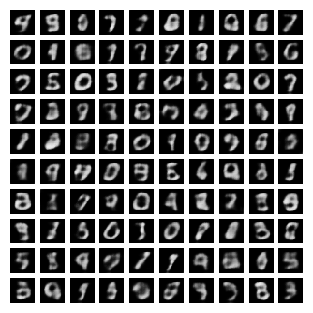

In [25]:
import torch
from src.utils.data_io import show_images


dec_model = dec_model.to(DEVICE)
dec_model.eval()

# 生成する画像の枚数
n_gen = 100

# 正規分布 N(Z_mu, Z_sigma^2) に従って適当に乱数ベクトルを作成（ Z_mu == 0, Z_sigma == 1 なら標準正規分布 ）
Z_mu = 0 # 正規分布の平均
Z_sigma = 1 # 正規分布の標準偏差
Z = Z_sigma * torch.randn((n_gen, N)).to(DEVICE) + Z_mu

# 乱数ベクトルをデコーダに入力し，その結果を表示
with torch.inference_mode():
    Y = dec_model(Z)
    show_images(Y.to('cpu').detach(), num=n_gen, title='AE_sample_MNIST_generated', save_fig=True)